# Credit Card Default Analysis - Part 2 Modeling

#### Default Payments of Credit Card Clients in Taiwan from 2005

## Table of Contents
- Import Packages
- Load Data
- Prepare for Modeling
- Predicative Classification Modeling
- Logistic Regression
- Random Forest
- XGBoost
- Model Comparison
- Conclusion

## Import Packages

In [13]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import warnings
warnings.simplefilter("ignore")
from pprint import pprint
import joblib
import imblearn

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn import metrics  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

## Load Data

In [14]:
data = pd.read_csv(r"C:\Python\Python392\UCI_Credit_Card_Processed.csv")
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'DEF_PAY_NMO'],
      dtype='object')

## Prepare for Modeling

### 1. Feature Engineering

In [15]:
# Bin ‘AGE’ data to 6 groups
bins= [21,30,40,50,60,70,80]
labels = list(range(6))
data['AGE'] = pd.cut(data['AGE'],bins=bins, labels=labels,right=False)

# Covert categorical column into integer by extracting the code of the categories
data.AGE = data.AGE.cat.codes
data.AGE

0        0
1        0
2        1
3        1
4        3
        ..
29995    1
29996    2
29997    1
29998    2
29999    2
Name: AGE, Length: 30000, dtype: int8

### 2. Feature Selection

In [16]:
# Define predictor variables and target variable
X = data.drop(columns=['ID','DEF_PAY_NMO'])
y = data['DEF_PAY_NMO']

# Save all feature names as list
feature_cols = X.columns.tolist() 

# Extract numerical columns and save as a list for rescaling
X_num = X.drop(columns=['SEX', 'EDUCATION', 'MARRIAGE', 'AGE'])
num_cols = X_num.columns.tolist()   

### 3. Check Class Imbalance

0    0.7788
1    0.2212
Name: DEF_PAY_NMO, dtype: float64


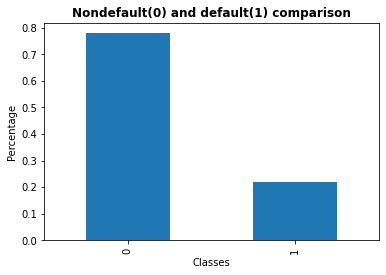

In [17]:
# Check target classes balancec
cla_bal = data['DEF_PAY_NMO'].value_counts(normalize=True)
print(cla_bal)

# Plot the classes
cla_bal.plot(kind = 'bar')
plt.title('Nondefault(0) and default(1) comparison',fontweight = "bold")
plt.xlabel('Classes')
plt.ylabel('Percentage')
plt.show()

With typical default classification problems, we expect imbalanced classes as we know most people will not default. This dataset is also imbalanced, with 78% non-default vs. 22% default. 

### 4. Split Training and Test Data

In [18]:
# Define function to split data with and without SMOTE 

def data_split(X, y, imbalance = False):
    # split data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True, stratify=y, random_state=42)
    
    if imbalance:
        # use SMOTE to over sample data
        from imblearn.over_sampling import SMOTE
        sm = SMOTE(random_state = 42)
        X_train, y_train = sm.fit_resample(X_train, y_train.ravel())
    
    return X_train, X_test, y_train, y_test

### 5. Rescale Features

In [19]:
# Define function to rescale training data using StandardScaler

def standard_scaler(X_train, X_test, numerical_cols):
    
    # Make copies of dataset
    X_train_std = X_train.copy()
    X_test_std = X_test.copy()
    
    # Apply standardization on numerical features only
    for i in numerical_cols:
        scl = StandardScaler().fit(X_train_std[[i]])     # fit on training data columns
        X_train_std[i] = scl.transform(X_train_std[[i]]) # transform the training data columns
        X_test_std[i] = scl.transform(X_test_std[[i]])   # transform the testing data columns
    
    return X_train_std,X_test_std

## Classification Predictive Modeling

### 1. Logistic Regression

Rescaling the features variables then run Logistic Regression with and without SMOTE sampling to compare ROC_AUC scores.

In [20]:
def run_logistic_regression(imbalance=False):
    # Split data  
    X_train, X_test, y_train, y_test = data_split(X, y, imbalance = imbalance)

    # Rescale data
    X_train_std, X_test_std = standard_scaler(X_train, X_test, numerical_cols = num_cols)
    
    # Instantiate model
    clf_lr = LogisticRegression(random_state=42)
    
    # Fit the model
    clf_lr.fit(X_train_std, y_train)

    # Use model's default parameters to get cross validation score
    scores = cross_val_score(clf_lr, X_train_std, y_train, scoring ="roc_auc", cv = 5)
    roc_auc_lr = np.mean(scores)
    
    if imbalance:
        return "Logistic Regression", "With SMOTE", roc_auc_lr
    else:
        return "Logistic Regression", "Without SMOTE", roc_auc_lr

model_result = []
model_result.append(run_logistic_regression())
model_result.append(run_logistic_regression(imbalance=True))

pd.DataFrame(model_result, columns = ["Model", "SMOTE", "ROC_AUC Score"])

,Model,SMOTE,ROC_AUC Score
0,Logistic Regression,Without SMOTE,0.725559
1,Logistic Regression,With SMOTE,0.797031


Since SMOTE sampling yields a much better ROC_AUC score on training data, we will use SMOTE while tuning the model.

#### Tune Parameters of Logistic Regression

In [23]:
# Randomized search for the best C parameter

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Split data with SMOTE 
X_train, X_test, y_train, y_test = data_split(X, y, imbalance = True) 

# Rescale data
X_train_std, X_test_std = standard_scaler(X_train, X_test, numerical_cols = num_cols)

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,random_state=42)
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=42)

lr_best= clf.fit(X_train_std, y_train)   

print(lr_best.best_params_)

{'C': 0.23233444867279784, 'penalty': 'l1'}


In [25]:
# Save tuned model and parameters

joblib.dump(lr_best,r"C:\Python\Python392\logreg_sm_tuned.pkl") 

['C:\\Python\\Python392\\logreg_sm_tuned.pkl']

In [26]:
lr_best = joblib.load(r"C:\Python\Python392\logreg_sm_tuned.pkl")

In [27]:
# Get ROC_AUC score of tuned model on training data

scores_tuned = cross_val_score(lr_best, X_train_std, y_train, scoring = "roc_auc", cv = 5)
roc_auc_lr_best = np.mean(scores_tuned)

print(f'ROC_AUC score after tuning parameters:{roc_auc_lr_best:.3f}')

ROC_AUC score after tuning parameters:0.792


In [28]:
# Save best ROC_AUC 

joblib.dump(roc_auc_lr_best,r"C:\Python\Python392\logreg_ROC_AUC_CV.pkl") 

['C:\\Python\\Python392\\logreg_ROC_AUC_CV.pkl']

In [29]:
roc_auc_lr_best = joblib.load(r"C:\Python\Python392\logreg_ROC_AUC_CV.pkl")
roc_auc_lr_best

0.7923062242223683

After fine-tuning parameter C, Logistic Regression model got ROC_AUC training score as 0.792, slightly decreased from original score 0.797. This could mean model is less overfitting the training data.

#### Logistic Regression Model Evaluation

#### Precision_Recall and F1 Score

In [30]:
# Define a function to compute Precision, Recall and F1 score

def get_pre_rec_f1(model,X_test,y_test):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    print(f'Precision:{precision:.3f}\nRecall:{recall:.3f}\nF1 score:{F1:.3f}')

In [32]:
# Calculate precision and recall of Logistic Regression model

print('Logistic Regression model on test data:')
get_pre_rec_f1(lr_best, X_test_std, y_test)

Logistic Regression model on test data:
Precision:0.384
Recall:0.564
F1 score:0.457


#### Model Performance:
The business nature of credit card default analysis requires model to have a high recall. Logstic Regression model has a recall as 0.566. Let's look at another model - Random Forest to see if we can get a better recall.

### 2. Random Forest

Tree based model does not need feature to be rescaled, so we will skip rescaling step.

In [33]:
def run_random_forest(imbalance=False):
    # Split data  
    X_train, X_test, y_train, y_test = data_split(X, y, imbalance = imbalance)
    
    # Instantiate model
    clf_rf = RandomForestClassifier()
   
    # Fit the model
    clf_rf.fit(X_train, y_train)

    # Use model's default parameters to get cross validation score
    scores = cross_val_score(clf_rf, X_train, y_train, scoring ="roc_auc", cv = 5)
    roc_auc_rf = np.mean(scores)
    
    if imbalance:
        return "Random Forest", "With SMOTE", roc_auc_rf
    else:
        return "Random Forest", "Without SMOTE", roc_auc_rf

model_result = []
model_result.append(run_random_forest())
model_result.append(run_random_forest(imbalance=True))

pd.DataFrame(model_result, columns = ["Model", "SMOTE", "ROC_AUC Score"])

,Model,SMOTE,ROC_AUC Score
0,Random Forest,Without SMOTE,0.762039
1,Random Forest,With SMOTE,0.915947


Again, SMOTE sampling has a better performance. With the default parameters, Random Forest model generated ROC-AUC score 0.916 on training data, which is better than Logistic Regression model. Next, we will try to fine tune the hyperparameters with SMOTE sampling.

#### Tune Parameters of Random Forest

In [34]:
# Split data with SMOTE
X_train_sm, X_test, y_train_sm, y_test = data_split(X, y, imbalance = True)

In [35]:
# Create parameter grid  
param_grid = {
    'max_depth': [60, 90, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Instantiate the model
clf_rf = RandomForestClassifier()

# Instantiate grid search model
grid_search = GridSearchCV(estimator = clf_rf, param_grid = param_grid,    
                          cv = 3, n_jobs = -1, verbose = 1)

# Fit grid search to the data
grid_search.fit(X_train_sm, y_train_sm)
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'max_depth': 90,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [36]:
# Save tuned model

joblib.dump(grid_search,r"C:\Python\Python392\RandomForest_tuned_final.pkl")

['C:\\Python\\Python392\\RandomForest_tuned_final.pkl']

In [37]:
grid_search = joblib.load(r"C:\Python\Python392\RandomForest_tuned_final.pkl")

In [38]:
# Use the best parameters to fit the model

rf_best = RandomForestClassifier(**grid_search.best_params_)   
rf_best.fit(X_train_sm,y_train_sm)

scores_best = cross_val_score(rf_best, X_train_sm, y_train_sm, scoring ="roc_auc", cv = 5)
roc_auc_best = np.mean(scores_best)

print(f'ROC_AUC training score after tuning for Random Forest: {roc_auc_best:.3f}')

ROC_AUC training score after tuning for Random Forest: 0.907


After tuning parameters, Random Forest model's ROC-AUC score decreased slightly to 0.906.

#### Random Forest Model Evaluation

#### Precision_Recall and F1 Score

In [40]:
# Compute precision, recall and F1 score of Random Forest model on test data

print('Random Forest model on test data:')
get_pre_rec_f1(rf_best, X_test, y_test)

Random Forest model on test data:
Precision:0.511
Recall:0.515
F1 score:0.513


#### Model Performance:

Random Forest has recall rate as 0.515 and F1 score as 0.513. Now we will try another model XGBoost.

## Model Comparison

#### Confusion Matrix

Text(0.5, 1.0, 'Random Forest')

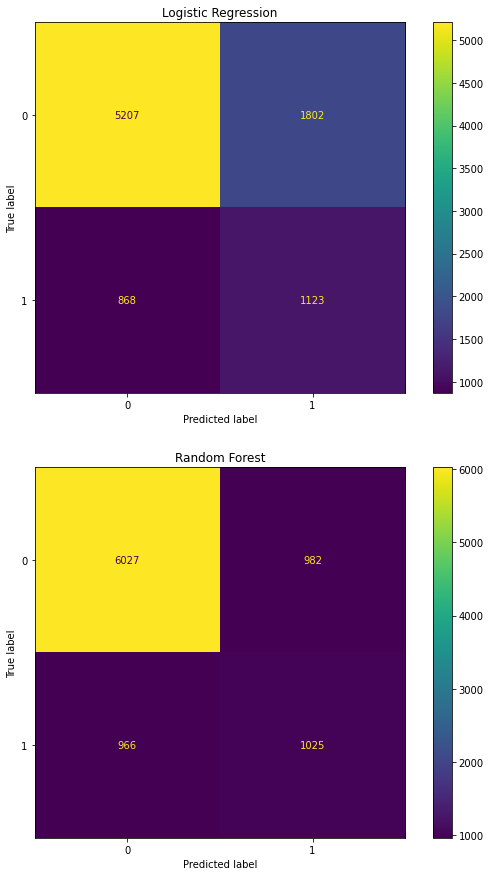

In [42]:
# Plot confusion matrix of 2 models

fig,ax=plt.subplots(2,1, figsize=(10,15))

plot_confusion_matrix(lr_best, X_test_std, y_test, ax = ax[0], values_format="d")
ax[0].set_title("Logistic Regression")

plot_confusion_matrix(rf_best, X_test, y_test, ax = ax[1], values_format="d")
ax[1].set_title("Random Forest")


#### ROC_AUC Curve

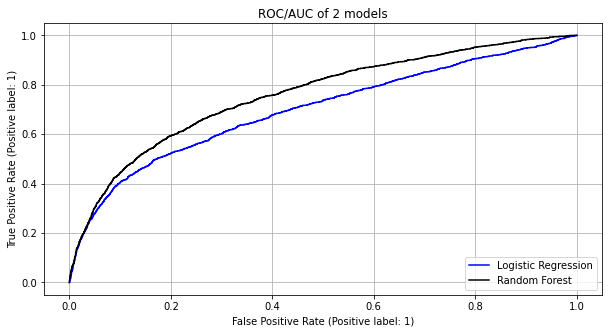

In [43]:
# Plot ROC_AUC curve of 2 models
 
fig,ax=plt.subplots(figsize=(10,5))

plot_roc_curve(lr_best, X_test_std, y_test,ax=ax, color="blue",label='Logistic Regression')
plot_roc_curve(rf_best, X_test, y_test,ax=ax, color="black",label='Random Forest')


plt.title('ROC/AUC of 2 models')
plt.grid()

#### Precision_Recall Curve

Since the classes are imbalanced, precision_recall curve is more approriate.

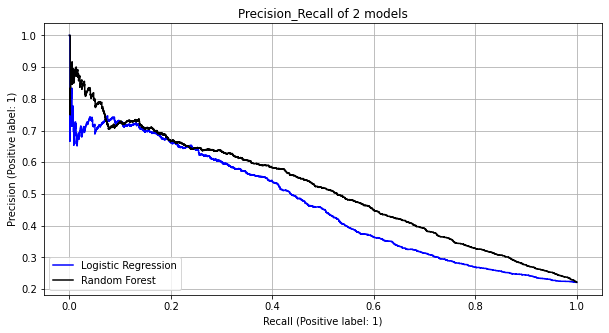

In [46]:
# Compare 2 models' Precision_recall curves

fig,ax=plt.subplots(figsize=(10,5))

plot_precision_recall_curve(lr_best, X_test_std, y_test, ax=ax,color="blue",label='Logistic Regression')
plot_precision_recall_curve(rf_best, X_test, y_test, ax=ax,color="black",label='Random Forest')


plt.title('Precision_Recall of 2 models')
plt.grid()

#### Compare Models with DummyClassifier

In [47]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
y_pred_dummy = dummy_clf.predict(X_test)

print('Dummy model:')
get_pre_rec_f1(dummy_clf, X_test, y_test)

Dummy model:
Precision:0.219
Recall:0.499
F1 score:0.304


All 3 models outperformed the dummy classifier's performance. Logistic Regression model has the best recall and Random Forest has the best Precision_Recall balance. 

| Models|Precision|Recall|F1 Score|Conclusion|
| --- | --- | --- | --- |--- |
| Dummy Model|0.217|0.500|0.303|Benchmark|
| Logistic Regression|0.384|0.566|0.457|Best recall|
| Random Forest|0.512|0.515|0.514|Best model|


#### Model Recommendation

We recommend recall = 0.8, however, the threshold can be adjusted to reach higher recall.

In [37]:
# Compute precision, recall and threshold of Random Forest

y_predict_rf = rf_best.predict_proba(X_test)
y_scores_rf = y_predict_rf[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_rf)

recalls_80 = recalls[np.argmin(recalls >= 0.80)]               # Recommend recall score = 0.8
precision_80 = precisions[np.argmin(recalls >= 0.80)]
threshold_80_recall = thresholds[np.argmin(recalls >= 0.80)]

thresholds = np.append(thresholds, 1)

recalls_80, precision_80, threshold_80_recall


(0.7995981918633852, 0.32757201646090534, 0.25616421313109144)

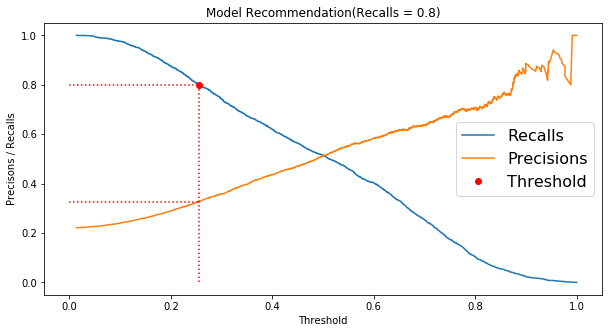

In [50]:
# Plot recommended recall = 0.8

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(thresholds, recalls, label='Recalls')
ax.plot(thresholds, precisions, label='Precisions')

ax.plot([threshold_80_recall, threshold_80_recall], [precision_80, recalls_80], "r:" )
ax.plot([threshold_80_recall, threshold_80_recall], [0, precision_80], "r:")
ax.plot([0, threshold_80_recall], [precision_80, precision_80], "r:")
ax.plot([0, threshold_80_recall], [recalls_80, recalls_80], "r:")
ax.plot([threshold_80_recall], [recalls_80], "ro", label='Threshold')

ax.set_xlabel('Threshold')
ax.set_ylabel('Precisons / Recalls')
ax.legend(loc='center right',fontsize=16)
plt.title('Model Recommendation(Recalls = 0.8)')
plt.savefig('recommended_recall')
plt.show()


#### Feature Importances

Text(0.5, 1.0, 'Features importance')

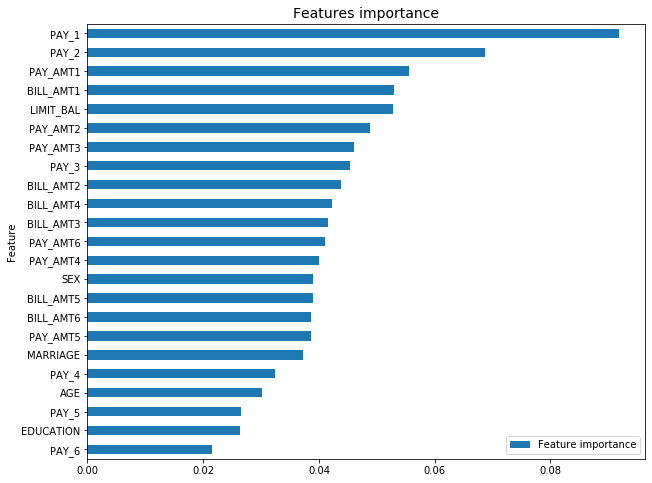

In [51]:
# Plot feature importance of winner model - Random Forest

fea_df = pd.DataFrame({'Feature': feature_cols, 'Feature importance': rf_best.feature_importances_})
fea_df = fea_df.sort_values(by='Feature importance')

figure, ax = plt.subplots(figsize = (10,8))
fea_df.plot.barh(x='Feature',y='Feature importance', ax=ax)
plt.title('Features importance',fontsize=14)

"PAY_1" AND "Pay_2" are the most recent 2 months' payment status and they are the strongest predictors of future payment default risk.

## Conclusion

Logistic Regression model has the highest recall but the lowest precision, if the business cares recall the most, then this model is the best candidate. If the balance of recall and precision is the most important metric, then Random Forest is the ideal model. Since Random Forest has slightly lower recall but much higher precision than Logistic Regression, I would recommend Random Forest. 